<a href="https://colab.research.google.com/github/evansuther/Google-Colab-Notebooks/blob/master/Prediction_of_School_Grades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression and Classification of Seconday School Grades
****
*Evan Suther*



I will be using the data and modifying the methods provided by Cortez and Silva (2008). The authors found that a neural net was less optimal than a decision tree for classification. I will be sticking with a neural net because for me, this notebook will mostly be an exploration of the data pre-processing necessary for using the data in a deep neural net - and less about achieving high accuracy in classification.



In [1]:
# will be used throughout notebook
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os

# download the data
dataset_path = keras.utils.get_file("student.zip", "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip")

# unzip the data
!unzip '$dataset_path'

24576/20478 [====================================] - 0s 1us/step
Archive:  /root/.keras/datasets/student.zip
  inflating: student-mat.csv         
  inflating: student-por.csv         
  inflating: student-merge.R         
  inflating: student.txt             


In [2]:
# process csv into pandas dataframe
math_df = pd.read_csv('student-mat.csv', delimiter=';') # much cleaner call than using numpy's genfromtext
portugese_df = pd.read_csv('student-por.csv', delimiter=";") 
# view the first five records
portugese_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


Quite a few nominal data columns in this data set. Additionally, we have binary columns such as school, sex, schoolsup etc. 

In [4]:
# testing/playing with some pandas tools
active_kids = portugese_df.loc[portugese_df['activities'] == 'yes']
active_kids['G3'].mean()

12.104761904761904

## Narrowing the columns to the objective ones to be one-hot encoded

First, I encode the binary columns based on the information provided by Cortez and Silva. 

In [0]:
# Making manual encodings for binary values from the questionnairre 
binary_vals = {
    "school":{"GP": 0, "MS" : 1}, # not sure if school or sex should be kept as columns
    "sex":{"F": 0, "M": 1},       # even less sure if they should be made binaries
    "address":{"U": 0, "R": 1},
    "famsize":{"LE3": 0, "GT3": 1},
    "Pstatus":{"A": 0, "T": 1},
    "schoolsup":{"no": 0, "yes": 1},
    "famsup":{"no": 0, "yes": 1},
    "activities":{"no": 0, "yes": 1},
    "nursery":{"no": 0, "yes": 1},
    "paid":{"no": 0, "yes": 1},
    "internet":{"no": 0, "yes": 1},
    "romantic":{"no": 0, "yes": 1},
    "higher":{"no": 0, "yes": 1}
}
portugese_df.replace(binary_vals, inplace=True)
math_df.replace(binary_vals, inplace=True)

Next, I select the remaining objective columns

In [6]:
portugese_df.dtypes # lets see which columns are left to be encoded

school         int64
sex            int64
age            int64
address        int64
famsize        int64
Pstatus        int64
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup      int64
famsup         int64
paid           int64
activities     int64
nursery        int64
higher         int64
internet       int64
romantic       int64
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

In [7]:
# I will be using portugese_df because it's larger, I will not be merging the datasets 
# because I don't know if there is any overlap between the two sets(students who answered both questionnaires) 
objective_cols = portugese_df.select_dtypes(include='object')

# a quick check of which columns we got, and the data that came with
objective_cols[:1]

,Mjob,Fjob,reason,guardian
0,at_home,teacher,course,mother


Finally, I one-hot encode the objective columns.

In [8]:
# now I use pandas handy list shortcut to get the names of the columns containing objective data
obj_cols = list(objective_cols)
# get_dummies does one-hot encoding for us
encoded_obj_cols = pd.get_dummies(data=portugese_df, columns=obj_cols)
# a quick look at a changed entry
encoded_obj_cols[:1]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,0,1,0,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0


Now the objective columns have been one-hot encoded, and I display the first row to display this change

## Training a model to predict the grade of students based on their answers to the questionnaire

I will be training the model to predict final grade outcomes based on only the questionnaire answers. This means first, I have to remove the grades from the data set.

In [9]:
# create labels, G3 represents the final grade of the student
g3_labels = encoded_obj_cols['G3']
# Portugese grading is on a scale of 0-20, 10 is passing
passing = g3_labels.apply(lambda x: 1 if x >= 10 else 0)  
# remove labels and previous evaluations from data
x_no_grades = encoded_obj_cols.drop(columns=['G1', 'G2', 'G3'])
x_no_grades.shape

(649, 43)

#### Split data into train and test sets

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_no_grades, passing, test_size=0.2, random_state=42)
X_train.shape

(519, 43)

#### Build a Model

In [12]:
model = keras.Sequential()

Dense = keras.layers.Dense

model.add(Dense(30,input_shape=(43,), activation = "relu"))

model.add(Dense(15, activation = "relu"))

model.add(Dense(5, activation = "relu"))

model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = keras.optimizers.RMSprop(),
              loss = "binary_crossentropy",
              metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1320      
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
_________________________________________________________________


#### Train the model

In [13]:
# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, Y_train,
                    batch_size= 20,
                    validation_split=0.2,  
                    epochs = 50, 
                    )

# Evaluate the model's performance
train_loss, train_acc = model.evaluate(X_train, Y_train)
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

Train on 415 samples, validate on 104 samples
Epoch 1/50
415/415 [==============================] - 0s 1ms/sample - loss: 0.4811 - acc: 0.8265 - val_loss: 0.3843 - val_acc: 0.8750
Epoch 2/50
415/415 [==============================] - 0s 97us/sample - loss: 0.4526 - acc: 0.8265 - val_loss: 0.3761 - val_acc: 0.8750
Epoch 3/50
415/415 [==============================] - 0s 91us/sample - loss: 0.4324 - acc: 0.8265 - val_loss: 0.3569 - val_acc: 0.8750
Epoch 4/50
415/415 [==============================] - 0s 93us/sample - loss: 0.4286 - acc: 0.8265 - val_loss: 0.3525 - val_acc: 0.8750
Epoch 5/50
415/415 [==============================] - 0s 93us/sample - loss: 0.4153 - acc: 0.8265 - val_loss: 0.3433 - val_acc: 0.8750
Epoch 6/50
415/415 [==============================] - 0s 104us/sample - loss: 0.4056 - acc: 0.8265 - val_loss: 0.3540 - val_acc: 0.8750
Epoch 7/50
415/415 [==============================] - 0s 97us/sample - loss: 0.4014 - acc: 0.8217 - val_loss: 0.3402 - val_acc: 0.8750
Epoch 8/5

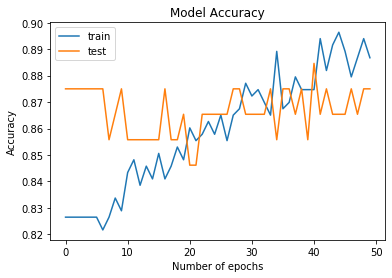

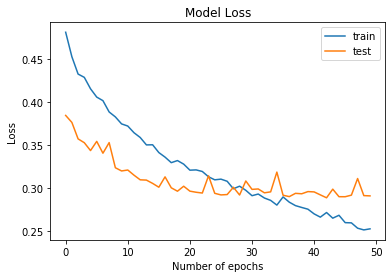

In [14]:
import matplotlib.pyplot as plt
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

The above plots show slight overfitting to the training set. I tuned the epochs spent training to account for this issue.

# Results

A simple neural net can predict whether a student will pass Portugese class with 87.6% accuracy using encoded answers from a questionnaire. The input configuration that my model was trained on mirrored Cortez and Silva's setup C, which means the input included no other/prior evaluations from the school term. My neural net ended up being slightly more accurate than Cortez and Silva's - who achieved 83.4% accuracy with the same input setup (Table 3, Cortez and Silva). I attribute this improvement to the difference in loss functions and improved optimization techniques. The purpose of this project for me was learning about one-hot encoding and data-prepocessing, not outdoing the researchers who provided this data.

# Acknowledgements

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. 
 